# 6.6 Sourcing & Analyzing Time-Series Data

This script contains the following:
1. Importing your libraries and data
2. Subsetting, wrangling, and cleaning time-series data
3. Time series analysis: decomposition
4. Testing for stationarity
5. Stationarizing the Federal Reserve Economic Data

# Importing libraries & Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'yQ89bK9dgqir6kSRfScH'

# Nominal Potential Gross Domestic Product

In [10]:
# Importing the Federal Reserve Economic Data "Nominal Potential Gross Domestic Product" variable.

data = quandl.get('FRED/GDPPOT')

In [4]:
# https://data.nasdaq.com/data/FRED-federal-reserve-economic-data

In [5]:
data.head(5)

,Value
Date,
1949-01-01,2102.982630
1949-04-01,2130.581305
1949-07-01,2159.340530
1949-10-01,2186.844859
1950-01-01,2216.058359


In [6]:
data.shape

(332, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

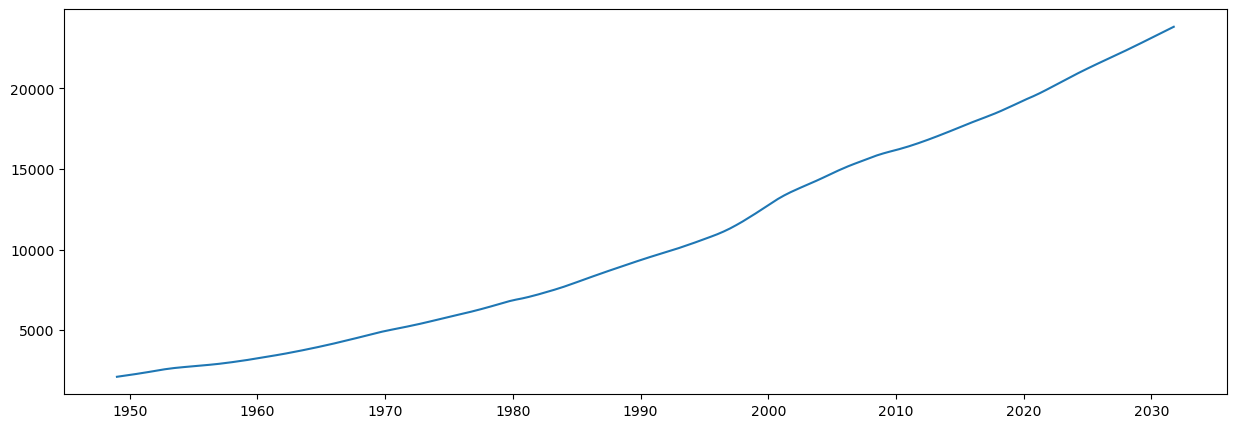

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

# 2. Subsetting, wrangling, and cleaning time-series data

In [11]:
# Reset index so the "Date" column is a filter

data_2 = data.reset_index()

In [16]:
data_2.shape

(332, 2)

In [12]:
data_2.head()

,Date,Value
0,1949-01-01,2102.982630
1,1949-04-01,2130.581305
2,1949-07-01,2159.340530
3,1949-10-01,2186.844859
4,1950-01-01,2216.058359


In [17]:
data_sub = data_2.loc[(data_2['Date'] >= '1990-01-01') & (data_2['Date'] < '2022-06-01')]

In [18]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

/var/folders/4r/1lzl881j3rxcxvg9h9jmpg6r0000gn/T/ipykernel_78437/421705488.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""


,Value
datetime,
1990-01-01,9344.347813
1990-04-01,9409.519331
1990-07-01,9473.370622
1990-10-01,9535.845016
1991-01-01,9597.373675


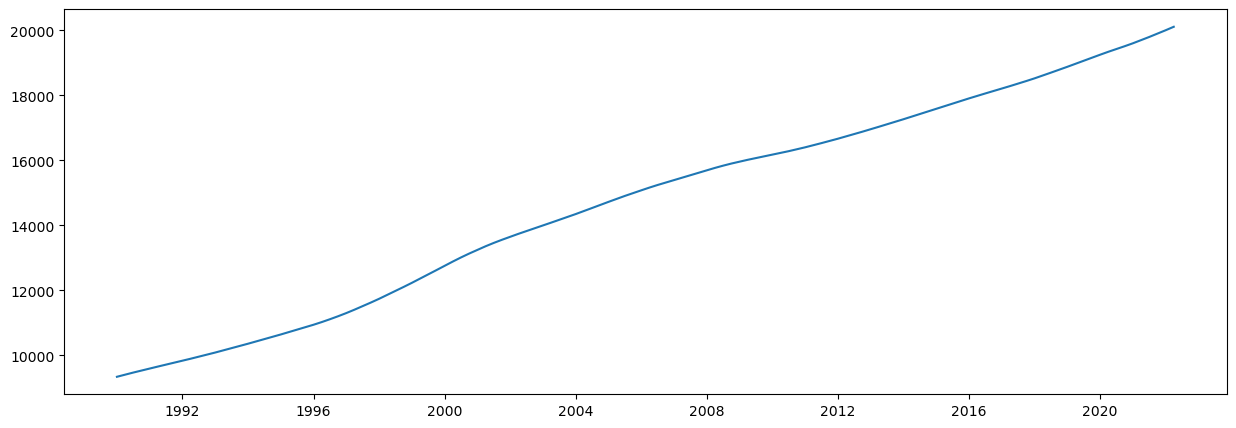

In [19]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [20]:
# Check for missing values 

data_sub.isnull().sum() 

Value    0
dtype: int64

In [21]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [22]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [25]:
from pylab import rcParams # To define a fixed size for all the special charts.

rcParams['figure.figsize'] = 18, 7

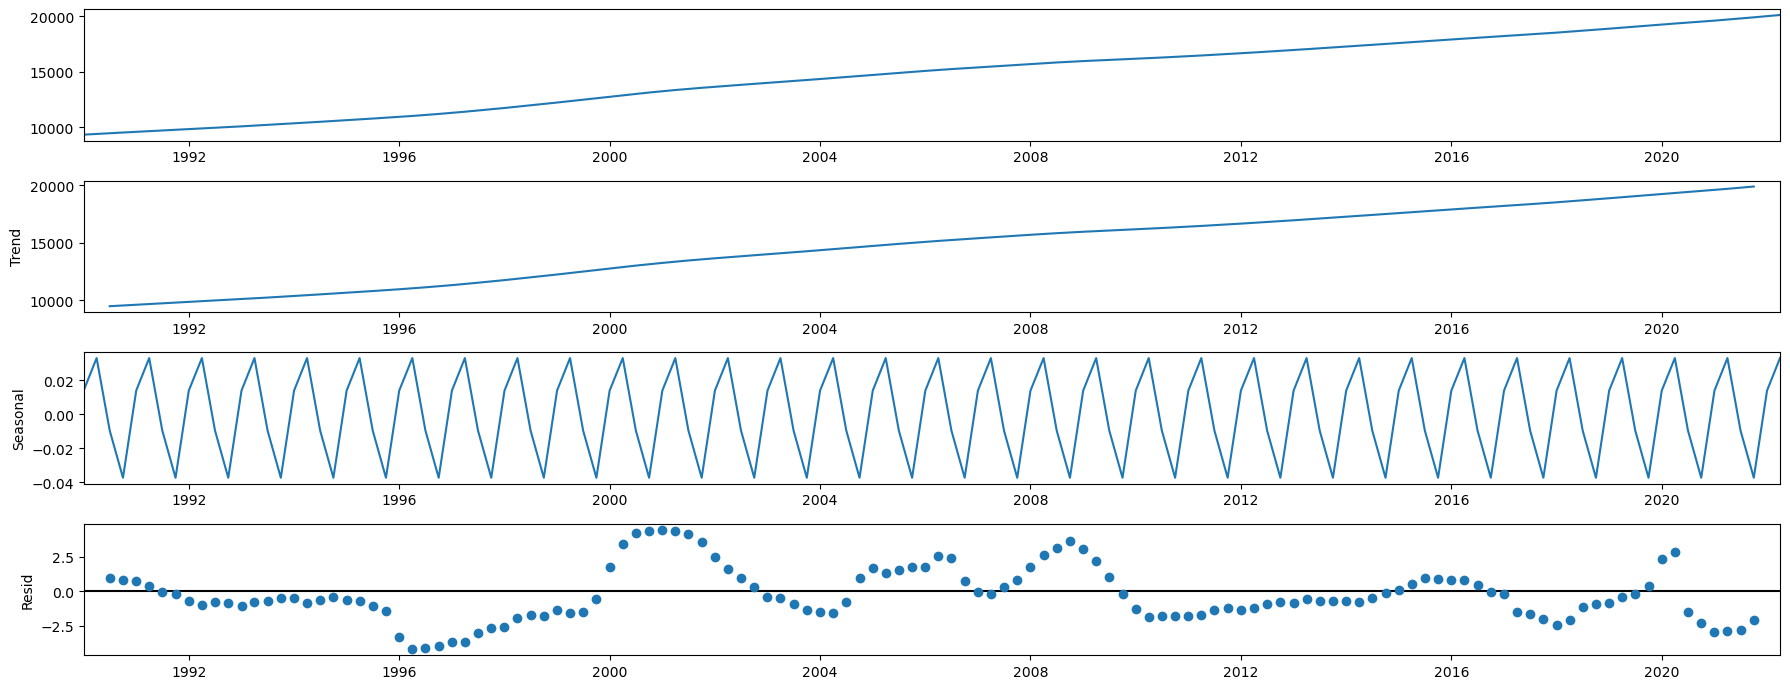

In [26]:
# Plot the separate components

decomposition.plot()
plt.show()

### 4. Testing for stationarity

In [27]:
# The adfuller() function...

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.278348
p-value                          0.928515
Number of Lags Used              2.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


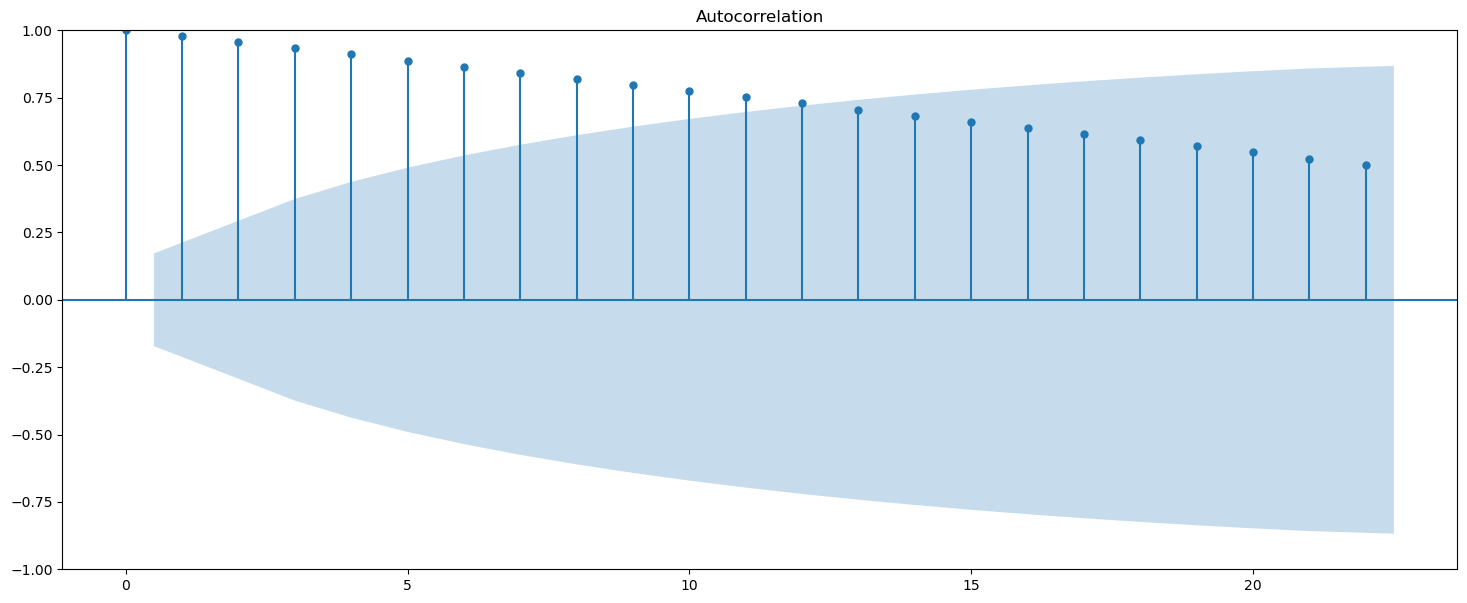

In [28]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### 5. Stationarizing the Federal Reserve Economic Data

In [29]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [30]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [31]:
data_diff.head()

,Value
datetime,
1990-04-01,65.171518
1990-07-01,63.851291
1990-10-01,62.474394
1991-01-01,61.528659
1991-04-01,60.423709


In [32]:
data_diff.columns

Index(['Value'], dtype='object')

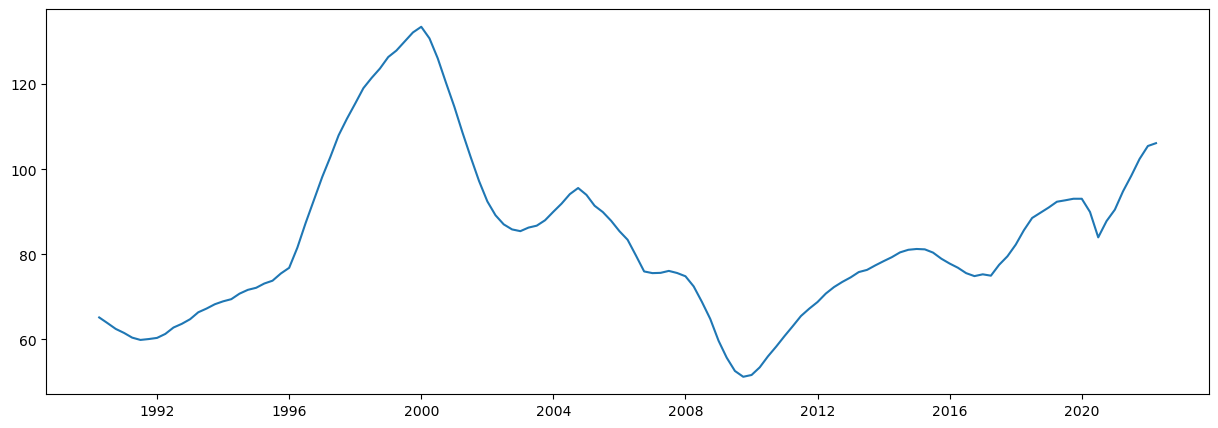

In [33]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [34]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.926792
p-value                          0.042320
Number of Lags Used              1.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


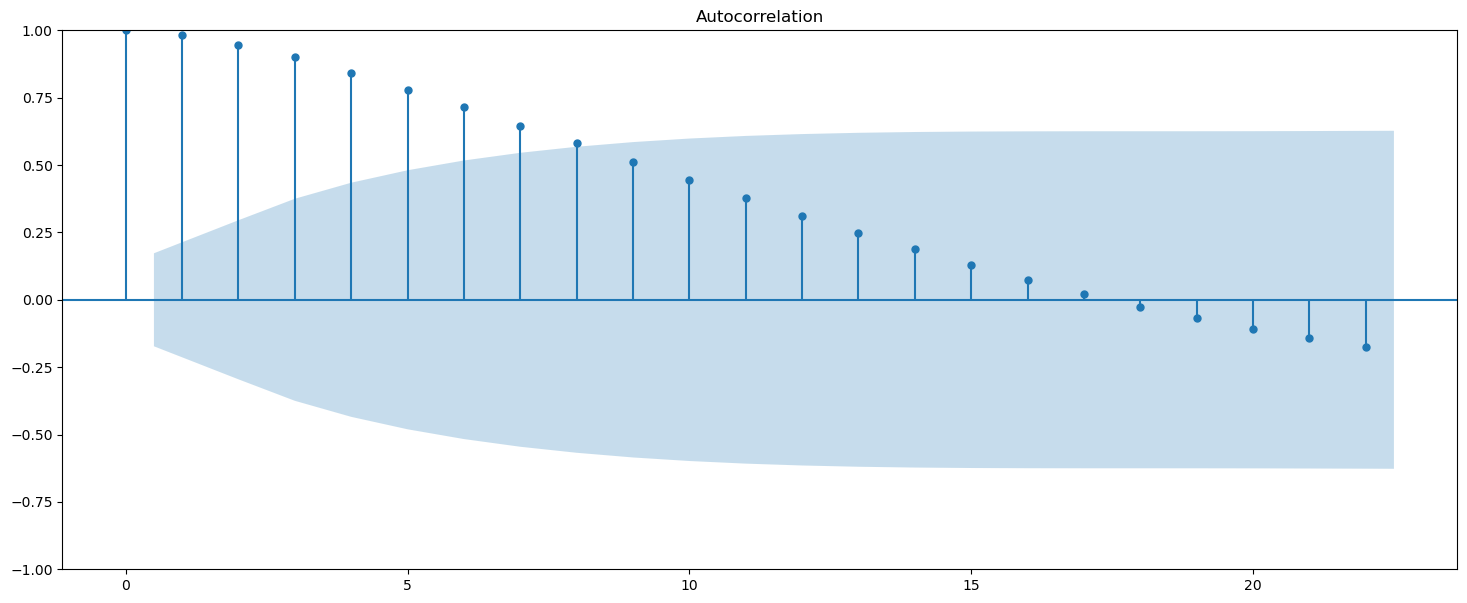

In [35]:
plot_acf(data_diff)
plt.show()